In [1]:
import torch
import matplotlib.pyplot as plt
from AutoEncoder import AutoEncoder
from stochman import nnj

plt.rcParams["font.family"] = "Times New Roman"

f_mnist = torch.load("picked_F_MNIST.t")
mnist = torch.load("picked_MNIST.t")

def encoder(data_dim, latent_dim):
	encoder = nnj.Sequential(
		nnj.Linear(data_dim, 500), nnj.ELU(),
		nnj.Linear(500,250), nnj.ELU(),
		nnj.Linear(250,150), nnj.ELU(),
		nnj.Linear(150,100), nnj.ELU(),
		nnj.Linear(100,50), nnj.ELU(),
		nnj.Linear(50,2)
		)
	return encoder

def decoder(data_dim, latent_dim):
	decoder = nnj.Sequential(
		nnj.Linear(2,50), nnj.ELU(),
		nnj.Linear(50,100), nnj.ELU(),
		nnj.Linear(100,150), nnj.ELU(),
		nnj.Linear(150,250), nnj.ELU(),
		nnj.Linear(250,500), nnj.ELU(),
		nnj.Linear(500,data_dim)
		)
	return decoder

experiment_name = 'reach_reg_new'
no_it = 200


# Loading models and loss curves
mnist_ae = AutoEncoder(encoder(784,2), decoder(784,2))
mnist_ae.load(f"{experiment_name}/{experiment_name}_reach_trained.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'reach_reg_new/reach_reg_new_reach_trained.pt'

In [2]:
# Load loss curves
pretrain_loss = torch.load(f"{experiment_name}/loss_curve.t")
l2_losses = torch.load(f"{experiment_name}/l2_losses_iter.pt")
reach_losses = torch.load(f"{experiment_name}/reach_losses.pt")
reach_points = torch.load(f"{experiment_name}/reach_points.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'reach_reg_new/l2_losses_iter.pt'

In [ ]:
# Percentage of points within reach
in_reach_per = torch.tensor(reach_points)/5000

In [ ]:
## Plotting the loss curves

ar = torch.arange(no_it)
fig, ax = plt.subplots(dpi = 150)
ax2 = ax.twinx()
ax.plot(torch.arange(10)+1, pretrain_loss[::500], color = 'green', linestyle = 'dotted', alpha = 0.5, label = 'L2-loss, 5000 epochs')
ax.plot(ar+10, l2_losses, label = 'L2-loss', linestyle = 'dashed')

#ax.plot(ar+10, reach_losses, label = 'reach loss')
ax2.plot(ar+10, (1-in_reach_per)*100, color = 'red', label = 'points within reach', linestyle = 'dashed')

ax.set_xlabel('Number of epochs')
ax.set_ylabel('L2-loss')
ax2.set_ylabel('Percentage of points within reach')
fig.legend(ncol = 4, loc = 9)
fig.savefig("initial_reach_regularisation.pdf")


### Visualizing latent representations

In [11]:
# For plotting
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm

# Importing mnist targets for plotting
mnist_target = torch.load("picked_MNIST_targest.t")


In [12]:
# Reach calculation in batches
def batch_cloud_reach_est(z_space,r,n_samples,batch_size, model):
    r_new = torch.zeros(len(z_space))
    enum_z_space = torch.cat((torch.arange(len(z_space)).unsqueeze(1), z_space),dim =1)
    loader = torch.utils.data.DataLoader(enum_z_space, batch_size = batch_size, shuffle = True)
    for batch in tqdm(loader):
        # Get jacobians
        batch_x, batch_jacs = model.decoder(batch[:,1:],jacobian = True)
        batch_r = r[batch[:,0].long()]
        n,d = batch_x.shape
        # Sample cloud points
        u = torch.randn(n,n_samples,d)
        u = u/torch.norm(u, dim = 2).unsqueeze(2)*((torch.rand(n,n_samples,1))**(1.0/d))*2*batch_r.unsqueeze(1).unsqueeze(1)
        cloud = u + batch_x.unsqueeze(1)
        # Project cloud points to manifold
        proj_cloud = model.decoder(model.encoder(cloud))-batch_x.unsqueeze(1)
        # Construct projection matrix
        proj_mat = torch.eye(d)-torch.linalg.lstsq(torch.transpose(batch_jacs,1,2),torch.transpose(batch_jacs,1,2)).solution
        # Calculate reach
        val = torch.min(torch.linalg.norm(proj_cloud,dim=2)**2/(2*torch.linalg.norm(torch.bmm(proj_mat, proj_cloud.movedim(1,2)),dim=1)),dim = 1).values
        r_new[batch[:,0].long()] = val.detach()
    
    return r_new

In [30]:
#ind_choice = torch.randint(5000,(2000,))
mnist_choice = mnist#[ind_choice]

In [31]:
### Calculations for the reach regularized model
mnist_error = torch.linalg.norm(mnist_choice-mnist_ae(mnist_choice),dim = 1)
mnist_r_2 = batch_cloud_reach_est(mnist_ae.encoder(mnist_choice),mnist_error, 1000, 10,mnist_ae )
mnist_in = mnist_error < mnist_r_2

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:59<00:00,  1.80s/it]


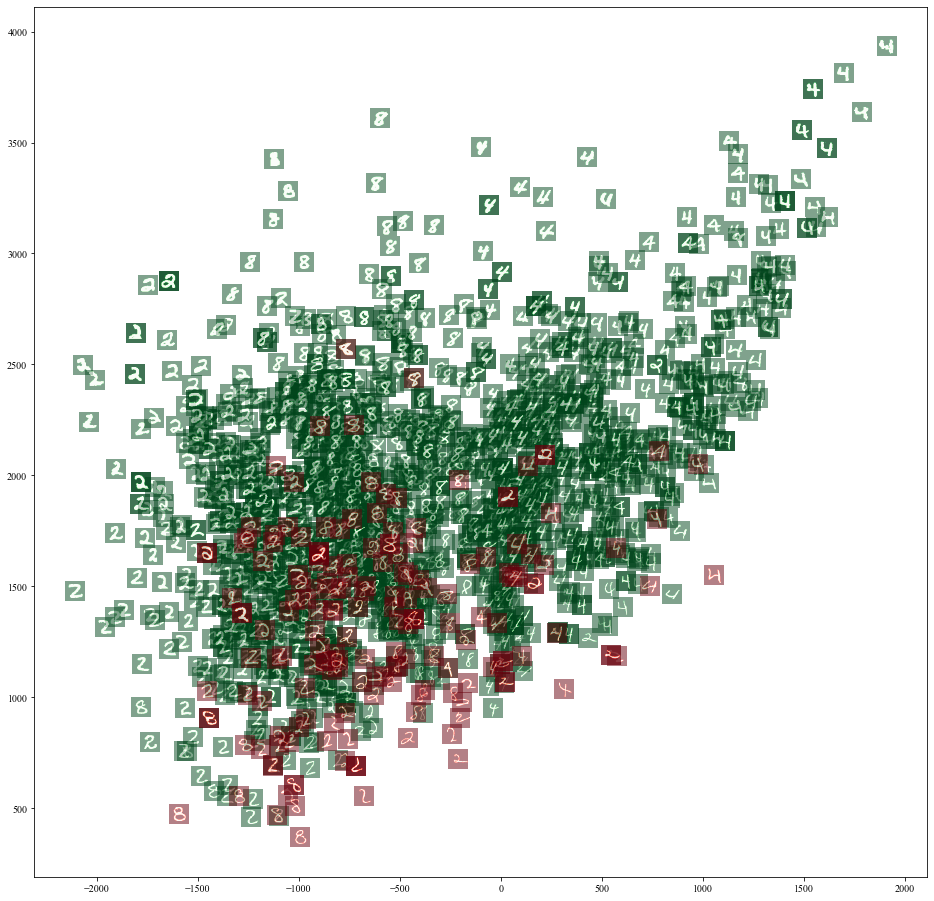

In [36]:
# Plot
zoom = 0.7
fig,ax = plt.subplots(figsize = (16,16))
mnist_z = mnist_ae.encoder(mnist_choice)
in_z = mnist_z[mnist_in]
mnist_im_in = mnist_choice[mnist_in]
for n in range(len(in_z)):
    image = mnist_im_in[n,:].detach().numpy().reshape((28,28))
    im = OffsetImage(image, zoom = zoom, cmap=plt.cm.Greens_r)
    ab = AnnotationBbox(im,(in_z[n,0].detach().numpy().flatten(), in_z[n,1].detach().numpy().flatten()), xycoords = 'data', frameon = False, alpha = 0.5)
    ax.add_artist(ab)
    ax.autoscale()
    ax.update_datalim([[in_z[:,0].detach().numpy().min(), in_z[:,1].detach().numpy().min()],
                   [in_z[:,0].detach().numpy().max(), in_z[:,1].detach().numpy().max()]])
    
out_z = mnist_z[~mnist_in]
mnist_im_out = mnist_choice[~mnist_in]
for n in range(len(out_z)):
    image = mnist_im_out[n,:].detach().numpy().reshape((28,28))
    im = OffsetImage(image, zoom = zoom, cmap=plt.cm.Reds_r, alpha = 0.5)
    ab = AnnotationBbox(im,(out_z[n,0].detach().numpy().flatten(), out_z[n,1].detach().numpy().flatten()), xycoords = 'data', frameon = False, alpha = 0.5)
    ax.add_artist(ab)
    ax.autoscale()
    ax.update_datalim([[out_z[:,0].detach().numpy().min(), out_z[:,1].detach().numpy().min()],
                   [out_z[:,0].detach().numpy().max(), out_z[:,1].detach().numpy().max()]])
fig.savefig("choice_regularized_latent.pdf", format = 'pdf')

In [16]:
### Pre-regularization AE
or_ae = AutoEncoder(encoder(784,2), decoder(784,2))
or_ae.load(f"{experiment_name}/{experiment_name}_ae_trained.pt")

In [17]:
# Calculate reach and determine points within reach
or_error = torch.linalg.norm(mnist-or_ae(mnist),dim = 1)
or_r_2 = batch_cloud_reach_est(or_ae.encoder(mnist),or_error, 1000, 10,or_ae )
or_in = or_error < or_r_2

100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [20:26<00:00,  1.75s/it]


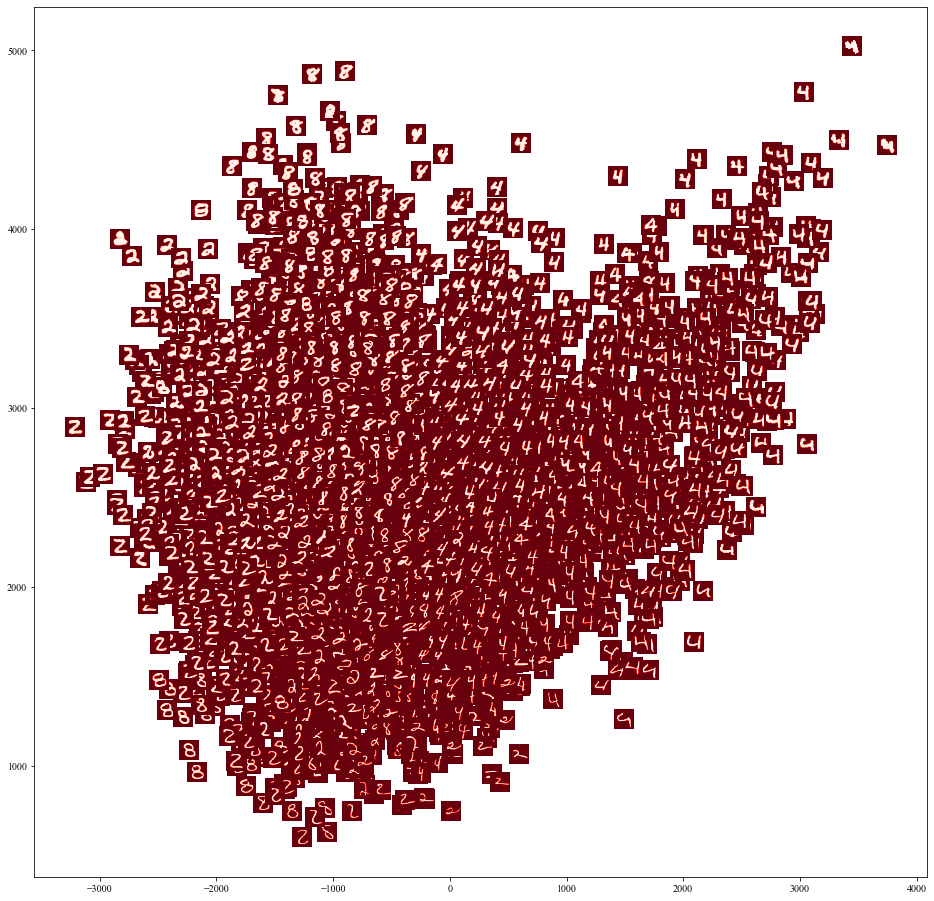

In [19]:
# Plot
zoom = 0.7
fig,ax = plt.subplots(figsize = (16,16))
or_z = or_ae.encoder(mnist)
in_z = or_z[or_in]
or_im_in = mnist[or_in]
for n in range(len(in_z)):
    image = or_im_in[n,:].detach().numpy().reshape((28,28))
    im = OffsetImage(image, zoom = zoom, cmap=plt.cm.Greens_r)
    ab = AnnotationBbox(im,(in_z[n,0].detach().numpy().flatten(), in_z[n,1].detach().numpy().flatten()), xycoords = 'data', frameon = False, alpha = 0.5)
    ax.add_artist(ab)
    ax.autoscale()
    ax.update_datalim([[in_z[:,0].detach().numpy().min(), in_z[:,1].detach().numpy().min()],
                   [in_z[:,0].detach().numpy().max(), in_z[:,1].detach().numpy().max()]])
    
out_z = or_z[~or_in]
or_im_out = mnist[~or_in]
for n in range(len(out_z)):
    image = or_im_out[n,:].detach().numpy().reshape((28,28))
    im = OffsetImage(image, zoom = zoom, cmap=plt.cm.Reds_r)
    ab = AnnotationBbox(im,(out_z[n,0].detach().numpy().flatten(), out_z[n,1].detach().numpy().flatten()), xycoords = 'data', frameon = False, alpha = 0.5)
    ax.add_artist(ab)
    ax.autoscale()
    ax.update_datalim([[out_z[:,0].detach().numpy().min(), out_z[:,1].detach().numpy().min()],
                   [out_z[:,0].detach().numpy().max(), out_z[:,1].detach().numpy().max()]])
fig.savefig("unregularized_latent.pdf", format = 'pdf')